In [1]:
modelPath = "Clickbait"
checkpoint = "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "single_label_classification" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 2                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type, # on pourra enlever ce paramètre si ca marche plus
   num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [0, 84602, 4, 6868, 3244, 307, 705, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['▁Hello', ',', '▁how', '▁are', '▁you', '?']
[0, 84602, 4, 6868, 3244, 307, 705, 2]
[84602, 4, 6868, 3244, 307, 705]
['<s>', '▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?', '</s>']
<s> Bonjour, comment ça va?</s>


In [5]:
import datasets as ds

In [6]:
curated = ds.load_from_disk(dataCuratedPath)

In [7]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
19533,Trump now agrees with the majority of American...,Donald Trump said being US president was harde...,Donald Trump spent a great portion of 2016 ins...,0.000000,858455355948384257
19534,Trump has flip-flopped. But his supporters are...,Trump Has Flip-Flopped. But His Supporters Are...,Barely over a tenth of Trump voters think his ...,0.266667,858459539296980995
19535,Inside North Korea's secret prisons,Inside Kim Jong-un's camps of death: Former No...,A female guard (stock photo) at a North Korean...,0.400000,858460992073863168
19536,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,“Inexcusable” failures in the UK’s system for ...,0.133333,858462320779026433


In [9]:
longueur= len(curated)
longueur

19538

In [10]:
trie=sorted(curated[LCfraction])

In [11]:
import matplotlib.pyplot as plt

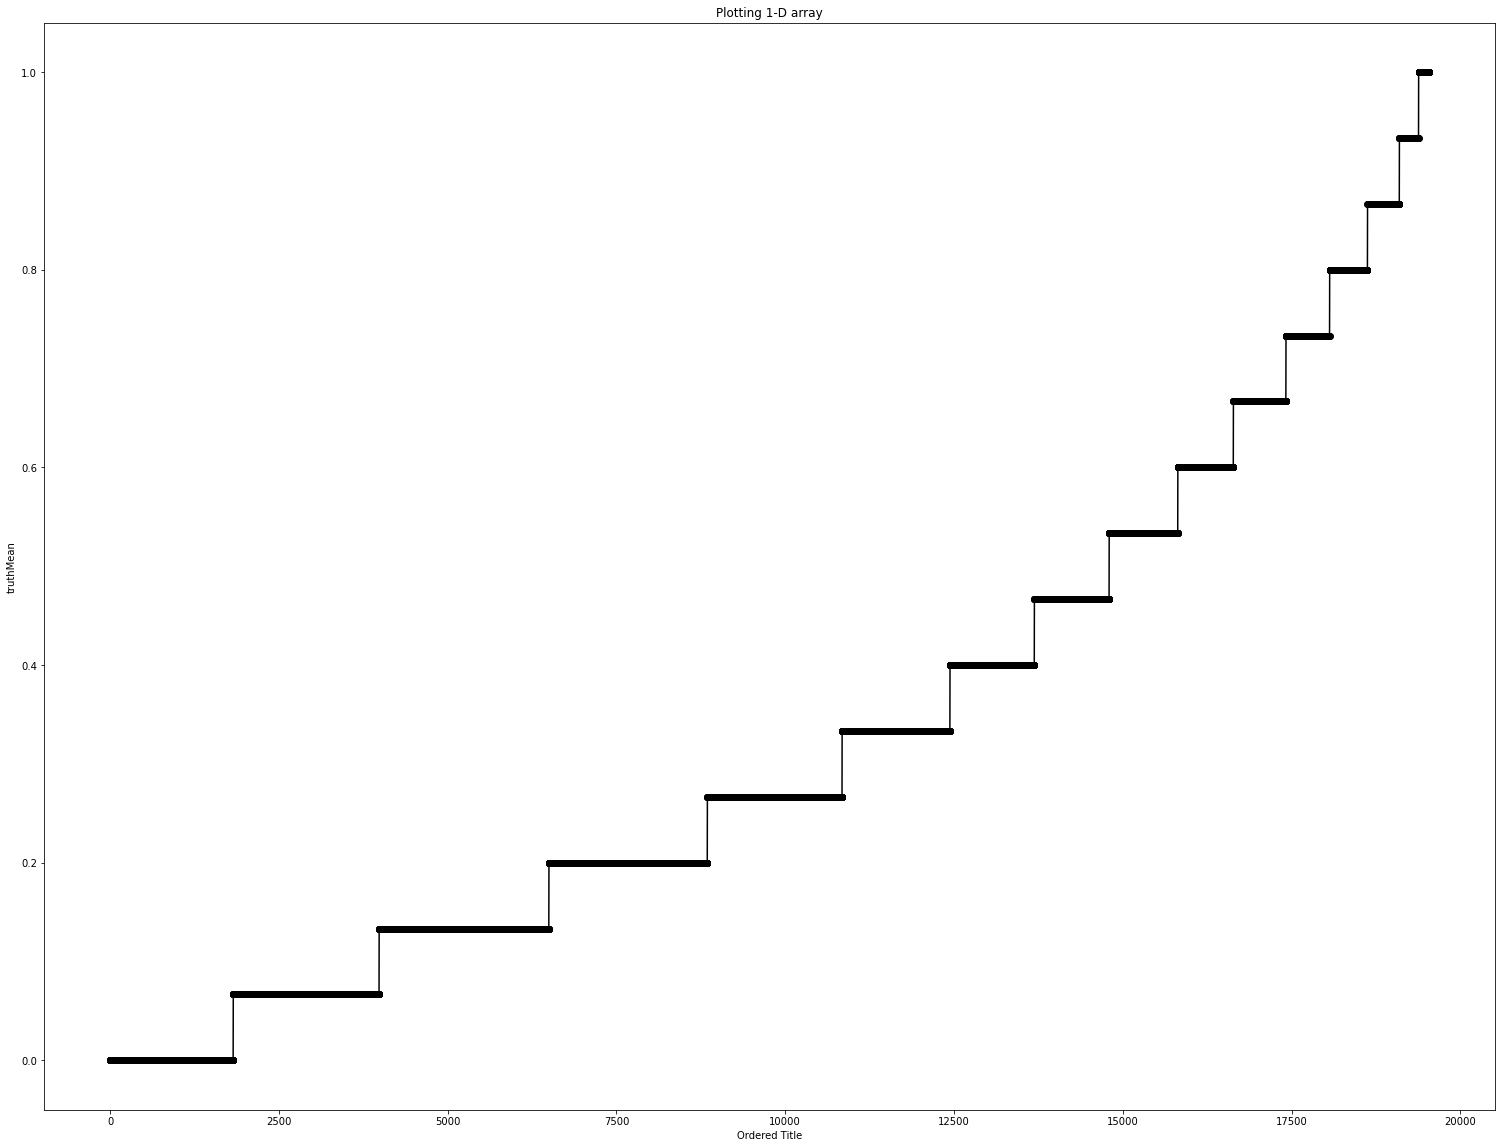

In [12]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [13]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[0.26666666664]

In [14]:
ncf[0]=0.5

In [15]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )
    fraction = sample[LCfraction]
    
    if num_labels == 1:
        tokenized_sample["label"] = fraction
    else:
        tokenized_sample["label"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["label"], sample[inputColumn])
    
    return tokenized_sample

In [16]:
tokenized_curated = curated.map(tokenize) #, batched=True)

Loading cached processed dataset at Data/Curated\cache-72f43ad15f4c6b55.arrow


In [17]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'attention_mask', 'label'],
    num_rows: 19538
})

In [18]:
tokenized_curated.to_pandas().describe()

,truthMean,label
count,19538.000000,19538.000000
mean,0.324530,0.242604
std,0.252824,0.428669
min,0.000000,0.000000
25%,0.133333,0.000000
50%,0.266667,0.000000
75%,0.466667,0.000000
max,1.000000,1.000000


In [19]:
print(tokenized_curated[0:3])

{'postText': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'The key to truly great chicken soup', 'Afghan policewomen face down their fears to serve'], 'targetTitle': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'A Superior Chicken Soup ', '100 Women 2016: On the frontline with the women policing the peace in Afghanistan'], 'targetDescription': ['Law enforcement agency analysis uncovers probable matches connected to terrorism, money laundering and organised crime', 'For the best rendition of this American classic, start with a whole bird.', 'The Afghan women risking all to join the police.'], 'truthMean': [0.06666666666, 0.73333333332, 0.33333333330000003], 'id': ['804113781580328960', '804119512010424320', '804121272967983104'], 'input_ids': [[0, 149674, 62323, 7, 12, 3939, 5877, 22317, 138, 4, 4283, 123055, 47, 92610, 297, 49602, 7, 2], [0, 581, 22799, 47, 87607, 6782, 143896, 101084, 2], [0, 57351, 1121, 35206, 3613, 1055, 2577, 7565, 236

In [20]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [21]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,label
0,Based Feminist vs. Zombie Galadriel,Camille Paglia Blasts Madonna’s ‘Humiliating’ ...,One of Madonna's earliest and most vocal femin...,0.466667,809408116777488384,"[0, 44978, 71, 227322, 20209, 5, 154551, 30733...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
1,Two people shot on freeway in Southern Califor...,Two people shot on Southern California freeway...,Two people shot on Southern California freeway...,0.066667,841956392445595648,"[0, 32964, 3395, 51876, 98, 4092, 7514, 23, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Texas Democrat sticks it to Republicans by pro...,Texas Democrat Sticks It to Republicans by Pro...,A Texas state rep has proposed legislation tha...,0.533333,841397210197647360,"[0, 31464, 138235, 47593, 7, 442, 47, 131161, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,Prominent Southern Baptist faces backlash over...,Baptist Figure Faces Backlash Over His Critici...,"Russell Moore, the public face of the Southern...",0.400000,810883599813775360,"[0, 1250, 7732, 18, 174715, 171403, 2577, 7, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,,U.S. Military Preparing to Deploy Laser Weapon...,"Laser weapons for planes, ships, and other veh...",0.200000,850889508103106560,"[0, 2]","[1, 1]",0
...,...,...,...,...,...,...,...,...
15625,Fourteen garden villages to be built in Englan...,Fourteen garden villages to be built in Englan...,Sites for new villages include green belt land...,0.066667,815711803426697216,"[0, 65056, 8927, 80583, 54427, 7, 47, 186, 883...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
15626,President Trump promises a busy 'day one' on M...,President Trump Signs 3 Presidential Memorandu...,President Trump promised a busy Day One for hi...,0.400000,823484115840364544,"[0, 34202, 5879, 103036, 7, 10, 86352, 242, 56...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
15627,Samsung has had a terrible run lately except f...,Samsung made a ton of cash even though its fla...,Rising like a Phoenix from the ashes of a.... ...,0.133333,857620130276278273,"[0, 8744, 1556, 1902, 10, 94176, 11675, 21, 37...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
15628,Russia KNEW about Syrian gas attack in advance...,Russia KNEW about Syrian gas attack in advance...,A senior U.S. official told the Associated Pre...,0.000000,851683571052027905,"[0, 49002, 100799, 111351, 1672, 51712, 19, 90...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [22]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [23]:
tokenized_curated4 = tokenized_curated3

In [24]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 15630
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 3908
    })
})

In [25]:
#tokenized_curated4.set_format("torch")

In [26]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  # learning_rate = 5e-4,
                                  weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [28]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[0, 44978, 71, 227322, 20209, 5, 154551, 30733, 14152, 583, 2], [0, 32964, 3395, 51876, 98, 4092, 7514, 23, 174715, 39897, 74, 17863, 669, 98, 5078, 184, 2], [0, 31464, 138235, 47593, 7, 442, 47, 131161, 7, 390, 48013, 214, 113093, 1363, 72124, 100, 453, 2], [0, 1250, 7732, 18, 174715, 171403, 2577, 7, 4420, 5544, 645, 2874, 9, 226584, 6, 116071, 2], [0, 2], [0, 80111, 12, 80799, 1274, 9248, 22799, 33946, 34515, 100, 17932, 1733, 23, 138, 21775, 74, 26073, 7, 22690, 51312, 7, 1221, 186, 128839, 5, 2], [0, 7082, 59226, 47, 14098, 145704, 157890, 1363, 32897, 242, 112, 22347, 1916, 25, 100, 166553, 2], [0, 192777, 8, 25500, 7, 1831, 2256, 13918, 237, 85853, 15595, 21161, 150631, 502, 372, 129745, 7, 2], [0, 11249, 11329, 7, 5809, 98834, 20650, 935, 11969, 3443, 53, 4343, 1829, 1374, 187001, 84511, 329, 2], [0, 33287, 1507, 87180, 8129, 5809, 186, 109133, 47, 15700, 31913, 23, 41640, 2], [0, 77987, 83, 16940, 68772, 116172, 4935, 240804, 7, 47, 27941, 7, 23, 6863, 4271, 525

In [30]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [31]:
# faire la boucle avec le trainer pytorch
# %pdb
trainer.train()

***** Running training *****
  Num examples = 15630
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3908


Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.465403,0.820368,0.472180
100,No log,0.526539,0.791965,0.296104
150,No log,0.424118,0.835466,0.551291
200,No log,0.431664,0.836745,0.560000
250,No log,0.390590,0.846725,0.708799
300,No log,0.416018,0.845957,0.609091
350,No log,0.407095,0.854657,0.669767
400,No log,0.373954,0.853889,0.677583
450,No log,0.379146,0.860287,0.681447
500,0.424900,0.354690,0.858751,0.699674


***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
Saving model checkpoint to Clickbait\checkpoint-500
Configuration saved in Clickbait\checkpoint-500\config.json
Model weights saved in Clickbait\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Clickbait\checkpoint-500\tokenizer_config.json
Special tokens file saved in Click

TrainOutput(global_step=650, training_loss=0.41025582533616284, metrics={'train_runtime': 133.0028, 'train_samples_per_second': 470.065, 'train_steps_per_second': 29.383, 'total_flos': 41783896119168.0, 'train_loss': 0.41025582533616284, 'epoch': 0.67})

In [32]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16


{'eval_loss': 0.3546901047229767,
 'eval_accuracy': 0.8587512794268168,
 'eval_f1': 0.6996735582154515,
 'eval_runtime': 4.8841,
 'eval_samples_per_second': 800.155,
 'eval_steps_per_second': 50.163,
 'epoch': 0.67}

In [33]:
# Sauver le modèle sur le disque
model.save_pretrained(modelPath)

Configuration saved in Clickbait\config.json
Model weights saved in Clickbait\pytorch_model.bin


In [34]:
tokenizer.save_vocabulary(modelPath)

('Clickbait\\sentencepiece.bpe.model',)

In [35]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "test" #  "train" # "test"

In [36]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated4[overfitting])

***** Running Prediction *****
  Num examples = 3908
  Batch size = 16


In [37]:
predictions.predictions

array([[ 1.2735801 , -1.340625  ],
       [-0.3927799 ,  0.467179  ],
       [ 1.2861173 , -1.3541358 ],
       ...,
       [ 1.277011  , -1.3430712 ],
       [ 1.2831893 , -1.350172  ],
       [-0.00211802,  0.06999502]], dtype=float32)

In [38]:
predictions.metrics

{'test_loss': 0.3546901047229767,
 'test_accuracy': 0.8587512794268168,
 'test_f1': 0.6996735582154515,
 'test_runtime': 5.615,
 'test_samples_per_second': 695.998,
 'test_steps_per_second': 43.633}

In [39]:
tct = tokenized_curated2[overfitting].to_pandas()

In [40]:
if num_labels == 1:
    tct["labelC"] = predictions.predictions
else:
    tct["labelC"] = np.argmax(predictions.predictions, axis=1)   

In [41]:
tct = tct.sort_values(LCfraction)

In [42]:
palette = ["r", "g", "b", "c", "m"]

In [43]:
if num_labels == 1:
    color = [val for val in tct["labelC"]]
else:
    color = [palette[val] for val in tct["labelC"]]

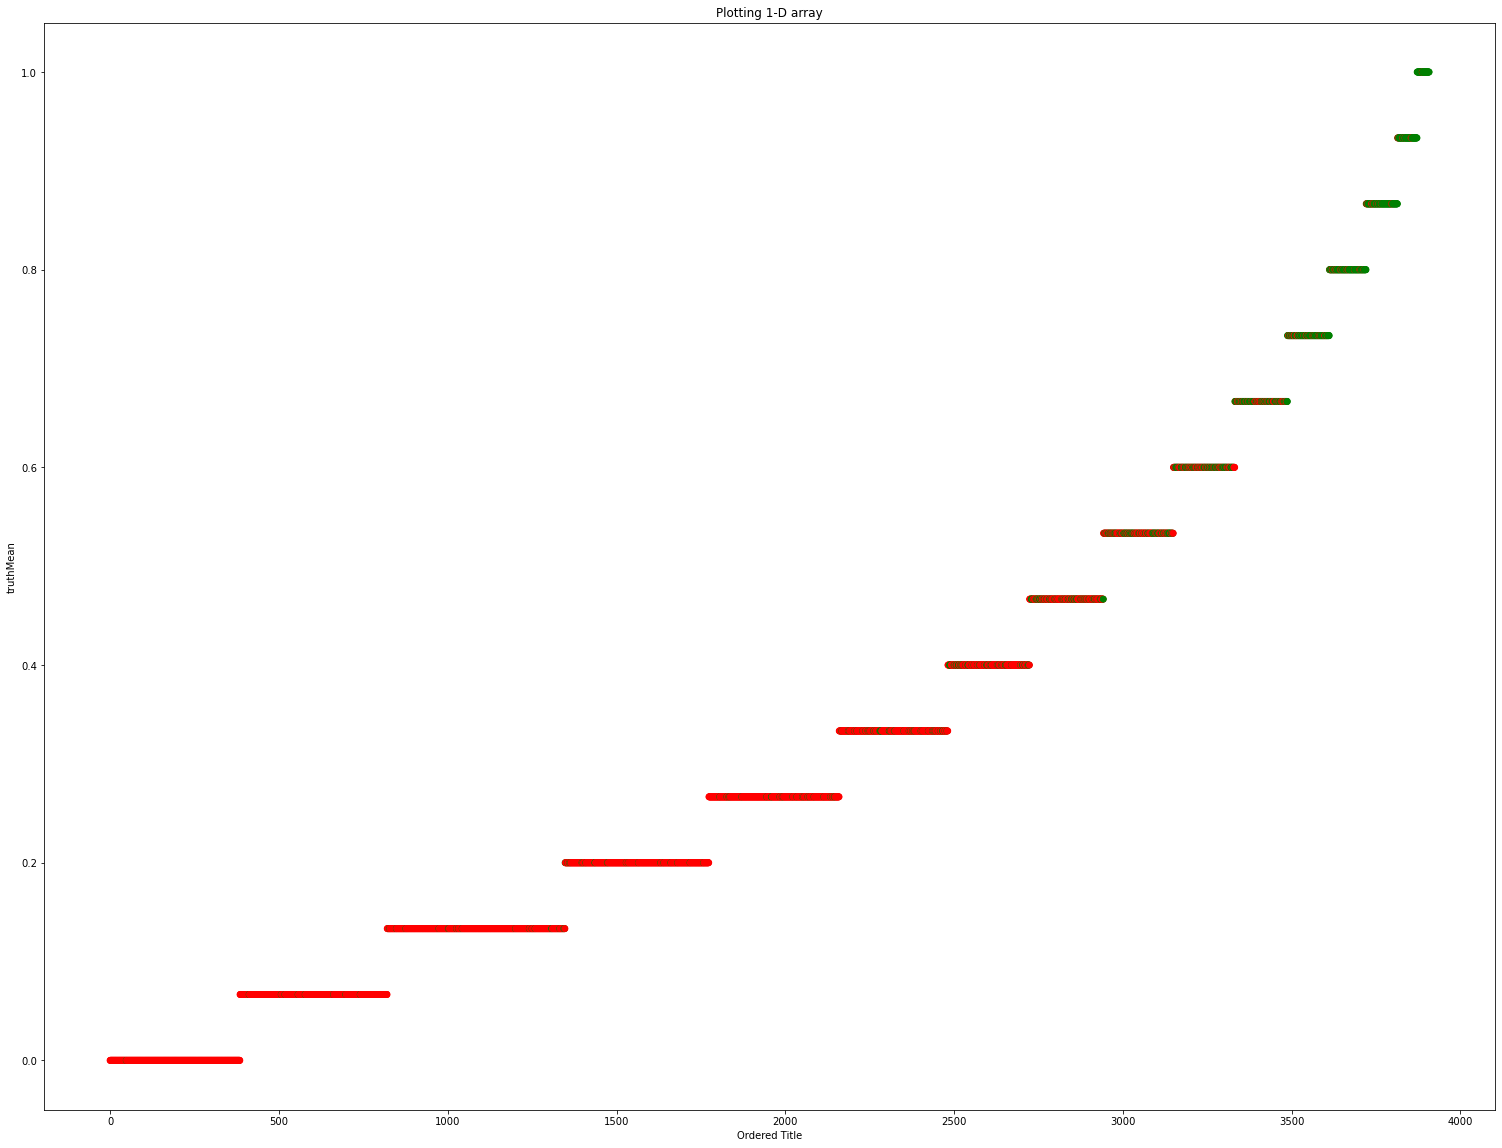

In [44]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction) #LCfraction
x = np.array(range(0, tct.shape[0]))
y = tct[LCfraction]
plt.scatter(x, y, c = color, marker = "o", label = "Array elements")

In [45]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,label,labelC
2922,Surprising report says the Patriots 'are not e...,Surprising report says the Patriots 'are not e...,The most desirable quarterback on the market t...,0.0,836948009879547904,"[0, 8018, 22876, 214, 13416, 17378, 70, 182857...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
2476,Derek Jeter-Jeb Bush group to purchase the Mar...,"Derek Jeter, Jeb Bush Group Reportedly Wins Au...",The group of buyers led by Derek Jeter and J...,0.0,856957358580400128,"[0, 1310, 343, 845, 720, 9, 11670, 275, 39591,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
2480,Chelsea Clinton joins Expedia board of directors,Chelsea Clinton joins Expedia board of directors,Chelsea Clinton joins Expedia board of directors,0.0,843369088680427520,"[0, 44517, 56485, 33284, 7, 138489, 11, 45443,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0
994,"Cambodia's Deputy PM Sok An dies aged 66, gove...","Cambodia's Deputy PM Sok An dies aged 66, gove...","Cambodia's Deputy Prime Minister Sok An, a clo...",0.0,842103593255682048,"[0, 105228, 25, 7, 76677, 53, 7198, 38789, 893...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
3761,"""We are orphans here"": Life and death in East ...",‘We Are Orphans Here’,Life and death in East Jerusalem’s Palestinian...,0.0,805138811126693888,"[0, 44, 12137, 621, 707, 68743, 7, 3688, 58, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0
...,...,...,...,...,...,...,...,...,...
2194,Oh goodie.,Erdogan: European Headscarf Ban ‘Started a Cla...,Erdogan said on Thursday that the EU's ban on ...,1.0,842774120660193280,"[0, 10160, 4127, 478, 5, 2]","[1, 1, 1, 1, 1, 1]",1,1
3602,#ICYMI: The social media problems gripping our...,The social media problems gripping our girls,It used to be a concern only for parents of te...,1.0,851389298506997761,"[0, 468, 16259, 1723, 10101, 12, 581, 2265, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,1
1565,The 3 longest flights in the world are not for...,The 3 Longest Flights In The World Are Not For...,Bring a book or five.,1.0,809808141428867072,"[0, 581, 138, 4989, 525, 113014, 7, 23, 70, 89...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1
1639,Hmmmmmm.,Al Gore Visits Trump Tower Seeking ‘Areas of C...,Al Gore Visits Trump Tower Seeking ‘Areas of C...,1.0,806106007973859328,"[0, 117434, 132687, 5, 2]","[1, 1, 1, 1, 1]",1,1


In [46]:
tct["labelC"].describe()

count    3908.000000
mean        0.223388
std         0.416570
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: labelC, dtype: float64

In [47]:
tct.corr()

,truthMean,label,labelC
truthMean,1.000000,0.837022,0.642124
label,0.837022,1.000000,0.608941
labelC,0.642124,0.608941,1.000000


In [48]:
from transformers import pipeline

In [49]:
model.to(torch.device("cpu"))
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [50]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")

[{'label': 'LABEL_1', 'score': 0.524410605430603}]

In [51]:
classifier(["The key to truly great chicken soup", "La clef d'une bonne soupe au poulet"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_1', 'score': 0.888286292552948},
 {'label': 'LABEL_1', 'score': 0.8356009721755981}]

In [52]:
classifier("Traité de mathématiques amusantes.")

[{'label': 'LABEL_1', 'score': 0.7792121767997742}]

In [53]:
tct.loc[tct.labelC != tct.label]

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,label,labelC
1969,🙏 RIP Alan Thicke 🙏,Alan Thicke Dies at 69,&#39;Growing Pains&#39; star Alan Thicke has d...,0.000000,808855586414718976,"[0, 6, 113612, 6, 132824, 44576, 19669, 20013,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,1
2097,This is what #Aleppo looked like before the wa...,This is what Aleppo looked like before the war,What the city looked like before the Syrian ci...,0.066667,810627817029386240,"[0, 3293, 83, 2367, 468, 117299, 34241, 54811,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1
1048,A look at the great Australian technology revival,Australia's Tech Underground Comes to Life,"Hello World, Episode 6: Bio-hackers, Internet ...",0.066667,816072582545965056,"[0, 62, 6713, 99, 70, 6782, 133836, 55556, 152...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,1
1854,The #bible is now available for #download in B...,Bible Society of India To Launch Bhojpuri App ...,"Coming Soon, A Bible App In Bhojpuri",0.066667,812988789547220992,"[0, 581, 468, 964, 2661, 83, 5036, 19882, 100,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,1
3423,These are the winners in this year's Sony Worl...,Sony World Photography Awards 2017: Winning ph...,The world's biggest photography competition --...,0.066667,847476647120953345,"[0, 32255, 621, 70, 159690, 7, 23, 903, 6602, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1
...,...,...,...,...,...,...,...,...,...
1308,"Mother gets cropped out of family photo, has f...","Mother gets cropped out of family photo, has f...",Abeera Tariq and her family all attended her c...,0.933333,813303338611642369,"[0, 115217, 62163, 13081, 48398, 1810, 111, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,0
2761,Valentine's Day is a busy time for private eye...,Valentine's is a busy time for private eyes - ...,The ones who hire them AREN'T spouses who fear...,0.933333,831465480472973312,"[0, 108749, 25, 7, 10013, 83, 10, 86352, 1733,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0
3031,#CyborgTrumpProblems aims to find Donald Trump...,#CyborgTrumpProblems Aims To Find Donald Trump...,Humanity has never been his strong suit.,0.933333,818919736058740737,"[0, 468, 441, 53, 10164, 226584, 223361, 7, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0
3088,Humans is returning for more,Humans season 3 confirmed by Channel 4 and AMC,TV series Humans is set to continue its global...,0.933333,846806100297105408,"[0, 28076, 7, 83, 30646, 214, 100, 1286, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",1,0


In [54]:
classifier("99% des gens n'arrivent pas à voir le chien sur cette image", return_all_scores=True)

[[{'label': 'LABEL_0', 'score': 0.13696689903736115},
  {'label': 'LABEL_1', 'score': 0.8630330562591553}]]